In [203]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
path_contract = "/content/drive/My Drive/final_provider/contract.csv"
path_internet = "/content/drive/My Drive/final_provider/internet.csv"
path_personal = "/content/drive/My Drive/final_provider/personal.csv"
path_phone = "/content/drive/My Drive/final_provider/phone.csv"

In [205]:
!pip install catboost

In [206]:
#libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
import catboost as cat

In [207]:
df_contract = pd.read_csv(path_contract)
df_internet = pd.read_csv(path_internet)
df_personal = pd.read_csv(path_personal)
df_phone = pd.read_csv(path_phone)

In [213]:
df_full = df_contract.set_index('customerID').join(df_phone.set_index('customerID'))

In [215]:
df_full['MultipleLines'].fillna('No',inplace = True)

In [216]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 815.2+ KB


In [217]:
df_full = df_full.join(df_personal.set_index('customerID'))

In [218]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.0+ MB


In [219]:
df_full = df_full.join(df_internet.set_index('customerID'))

In [220]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null 

In [221]:
df_full['InternetService'].fillna('No',inplace = True)
df_full['OnlineSecurity'].fillna('No',inplace = True)
df_full['OnlineBackup'].fillna('No',inplace = True)
df_full['DeviceProtection'].fillna('No',inplace = True)
df_full['TechSupport'].fillna('No',inplace = True)
df_full['StreamingTV'].fillna('No',inplace = True)
df_full['StreamingMovies'].fillna('No',inplace = True)

Изначально пытался сделать через df_full[['InternetService','OnlineSecurity'...]].fillna('No',inplace = True), но не удалось сделать в одну строчку

In [222]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null 

In [224]:
df_full['BeginDate']=pd.to_datetime(df_full['BeginDate'],format = '%Y-%m-%d')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


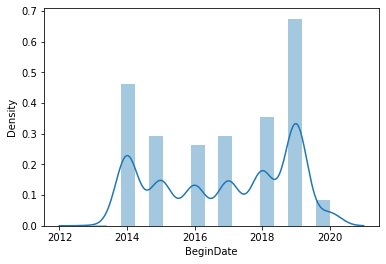

In [225]:
#Рост клиентов по годам
sns.distplot(df_full['BeginDate'].dt.year)

2014 год был очень успешный для телекома с большим количеством новых клиентов , и после такого скачка из года в гд по тихонечку количество новых пользователей начало расти , и заметен еще один скачек в 2019 году с очень большим приростом новых пользователей

In [226]:
begin_date=pd.to_datetime(df_contract.loc[df_contract['EndDate'] != 'No','BeginDate'],format = '%Y-%m-%d')
end_date=pd.to_datetime(df_contract.loc[df_contract['EndDate'] != 'No','EndDate'],format = '%Y-%m-%dT%H:%M:%S')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


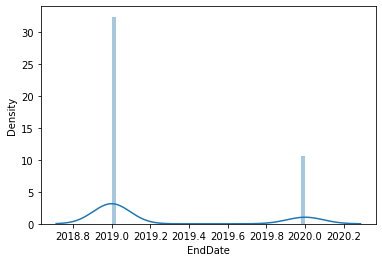

In [227]:
sns.distplot(end_date.dt.year)

Также видно ,что скачек по пользователям которые ушли приходится также на 2019 год и небольшой на 2020 

In [228]:
df_out=pd.concat([begin_date,end_date],axis=1)

In [229]:
df_out['lasted'] = df_out['EndDate'] - df_out['BeginDate']

In [230]:
df_out

,BeginDate,EndDate,lasted
2,2019-10-01,2019-12-01,61 days
4,2019-09-01,2019-11-01,61 days
5,2019-03-01,2019-11-01,245 days
8,2017-07-01,2019-11-01,853 days
13,2015-09-01,2019-10-01,1491 days
...,...,...,...
7021,2018-11-01,2019-11-01,365 days
7026,2019-02-01,2019-11-01,273 days
7032,2019-10-01,2019-11-01,31 days
7034,2014-03-01,2019-10-01,2040 days


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


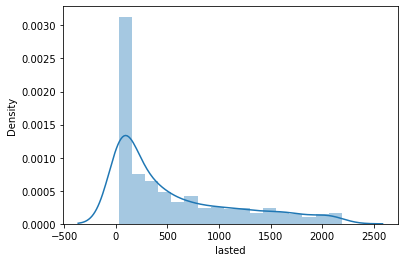

In [231]:
sns.distplot(df_out['lasted'].dt.days)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


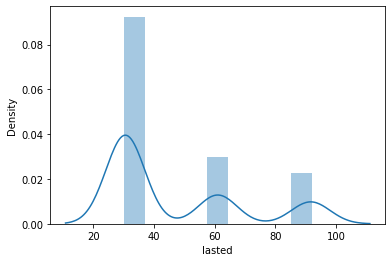

In [232]:
sns.distplot(df_out[df_out['lasted'].dt.days<100]['lasted'].dt.days)

Большое количество людей пользуется услугами всего месяц и уходит из телекома,возможно связано именно с завышенными ожиданиями клиента , либо в 2019 году телеком изменил свои тарифы или услуги , либо цены и большинство пользователей не устроили перемены и ушли - даже новые пользователи и старые

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


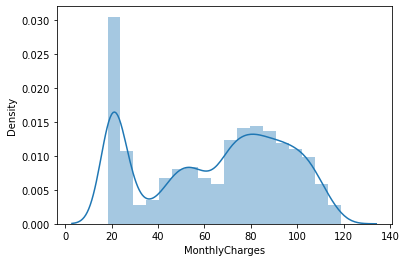

In [233]:
sns.distplot(df_full['MonthlyCharges'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


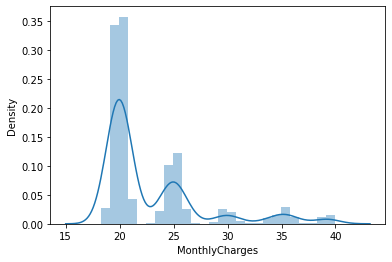

In [234]:
sns.distplot(df_full[df_full['MonthlyCharges'] < 40]['MonthlyCharges'])

В ежемесячной оплате заметно нормальное распределение для каждого тарифного плана , и основное количество пользователей видимо пользуются тарифом цены около 20

In [235]:
for i in range(len(df_full['TotalCharges'])):
  partition = df_full['TotalCharges'][i].partition('.')
  if (partition[0].isdigit() and partition[1] == '.' and partition[2].isdigit()) \
  or (partition[0] == '' and partition[1] == '.' and partition[2].isdigit()) \
  or (partition[0].isdigit() and partition[1] == '.' and partition[2] == ''):
    df_full['TotalCharges'][i] = float(df_full['TotalCharges'][i])
  else: 
    df_full['TotalCharges'][i] = 'NaN'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Проверка  TotalCharges на числовые string ,чтобы можно было отчленить от просто пустых строк ,либо не числовых строк и посчитать медиану и среднее ,так как данные указывают ,что пропусков нету ,но поработав с данными нашлись строки разного типа

In [236]:
total_charges = df_full[df_full['TotalCharges'] != 'NaN']['TotalCharges'].astype('float')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


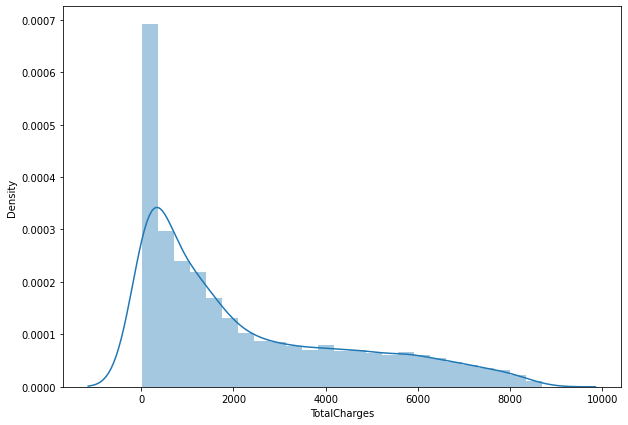

In [237]:
plt.figure(figsize=(10,7))
sns.distplot(total_charges)

In [238]:
print('Медиана Total Charges:',total_charges.median())
print('Среднее Total Charges:',total_charges.mean())

Медиана Total Charges: 1397.1
Среднее Total Charges: 2281.337462731072


In [241]:
((df_full['BeginDate'][0] - df_full['BeginDate'][1])/np.timedelta64(1, 'M')) * df_full['MonthlyCharges'][1]

1880.4410768188259

Для расчета общей оплаты берем месячную оплату и расчитываем количество месяцев до 2020-01-01, для людей которые еще пользуются. И для тех кто закончил берем разницы до финальной даты

In [242]:
final_date = df_full['BeginDate'][0]
df_full.loc[((df_full['TotalCharges'] == 'NaN') & (df_full['EndDate'] == 'No')),'TotalCharges'] = \
((final_date - df_full['BeginDate'])/np.timedelta64(1, 'M')) * df_full['MonthlyCharges']

In [243]:
df_full.loc[((df_full['TotalCharges'] == 'NaN') & (df_full['EndDate'] != 'No')),'TotalCharges'] = \
((pd.to_datetime(df_full[df_full['EndDate'] != 'No']['EndDate']) - df_full['BeginDate'])/np.timedelta64(1, 'M')) * df_full['MonthlyCharges']

In [244]:
df_full['TotalCharges'] = pd.to_numeric(df_full['TotalCharges'], downcast='float')

In [245]:
import seaborn as sns

OnlineSecurity 
 No     5024
Yes    2019
Name: OnlineSecurity, dtype: int64


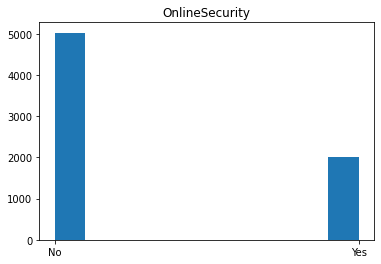

OnlineBackup 
 No     4614
Yes    2429
Name: OnlineBackup, dtype: int64


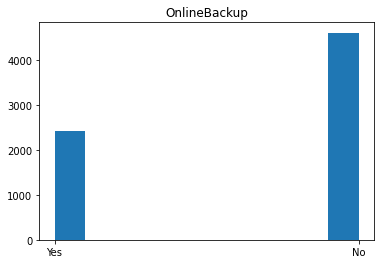

DeviceProtection 
 No     4621
Yes    2422
Name: DeviceProtection, dtype: int64


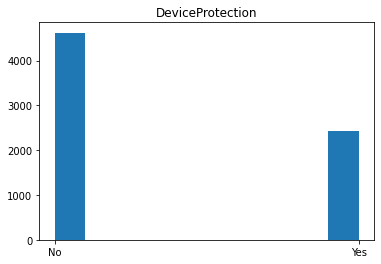

TechSupport 
 No     4999
Yes    2044
Name: TechSupport, dtype: int64


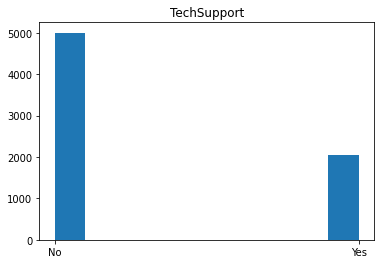

StreamingTV 
 No     4336
Yes    2707
Name: StreamingTV, dtype: int64


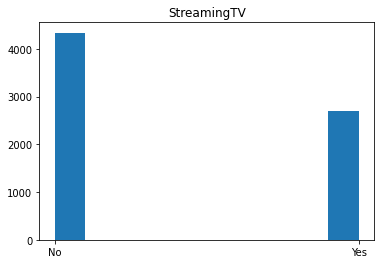

StreamingMovies 
 No     4311
Yes    2732
Name: StreamingMovies, dtype: int64


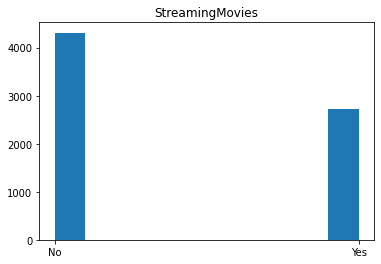

gender 
 Male      3555
Female    3488
Name: gender, dtype: int64


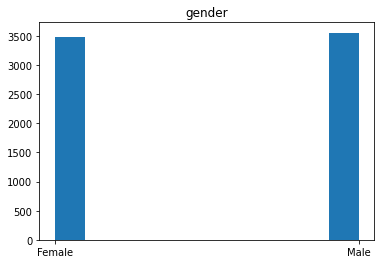

SeniorCitizen 
 0    5901
1    1142
Name: SeniorCitizen, dtype: int64


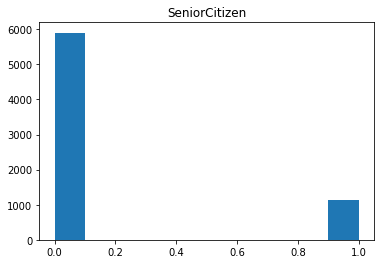

Partner 
 No     3641
Yes    3402
Name: Partner, dtype: int64


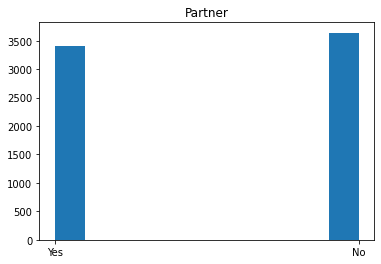

Dependents 
 No     4933
Yes    2110
Name: Dependents, dtype: int64


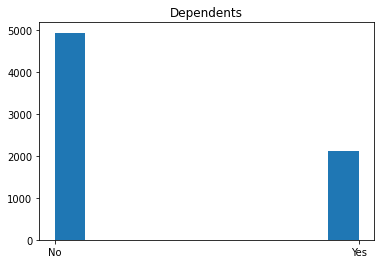

MultipleLines 
 No     4072
Yes    2971
Name: MultipleLines, dtype: int64


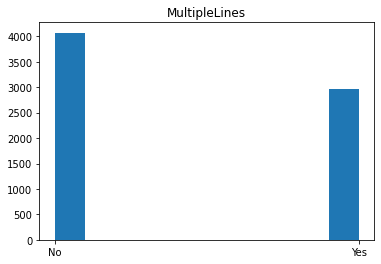

PaperlessBilling 
 Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64


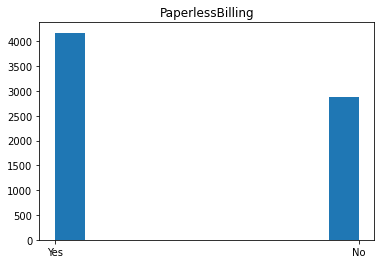

In [246]:
binary_col = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',\
              'StreamingMovies','gender','SeniorCitizen','Partner','Dependents','MultipleLines','PaperlessBilling']
for i in binary_col:
  print(i,'\n',df_full[i].value_counts())
  plt.hist(df_full[i])
  plt.title(i)
  plt.show()

Все переменные тут бинарные и примерно сбалансированы между собой без какого-то видимого дисбаланса за исключением зависимых людей финансово и людей в возрасте ,но тут дисбаланс логичен , ведь людям в возрасте нуждаются намного меньше ,чем молодое поколение
<br>
<br>
Также можно явно выделить ,что самая популярные услуги это Онлайн Безопасность и Техническая поддержка, а также большенство предпочитает получать чеки онлайн. Самая непопулярная услуга это мультилинии , но это понятно , ведь с ростом интернета доп услуги телефонии уже не так востребованы и нужны

In [247]:
#string Yes No переводим в 1 и 0 соответсвенно
df_full['MultipleLines'] = pd.Series(np.where(df_full['MultipleLines'].values == 'Yes', 1, 0),df_full.index)
df_full['Dependents'] = pd.Series(np.where(df_full['Dependents'].values == 'Yes', 1, 0),df_full.index)
df_full['Partner'] = pd.Series(np.where(df_full['Partner'].values == 'Yes', 1, 0),df_full.index)
df_full['gender'] = pd.Series(np.where(df_full['gender'].values == 'Female', 1, 0),df_full.index)
df_full['StreamingMovies'] = pd.Series(np.where(df_full['StreamingMovies'].values == 'Yes', 1, 0),df_full.index)
df_full['StreamingTV'] = pd.Series(np.where(df_full['StreamingTV'].values == 'Yes', 1, 0),df_full.index)
df_full['TechSupport'] = pd.Series(np.where(df_full['TechSupport'].values == 'Yes', 1, 0),df_full.index)
df_full['DeviceProtection'] = pd.Series(np.where(df_full['DeviceProtection'].values == 'Yes', 1, 0),df_full.index)
df_full['OnlineBackup'] = pd.Series(np.where(df_full['OnlineBackup'].values == 'Yes', 1, 0),df_full.index)
df_full['OnlineSecurity'] = pd.Series(np.where(df_full['OnlineSecurity'].values == 'Yes', 1, 0),df_full.index)
df_full['PaperlessBilling'] = pd.Series(np.where(df_full['PaperlessBilling'].values == 'Yes',1,0),df_full.index)

In [248]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float32       
 7   MultipleLines     7043 non-null   int64         
 8   gender            7043 non-null   int64         
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   int64         
 14  OnlineBackup  

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


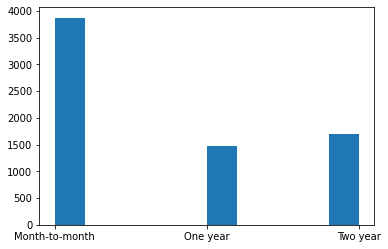

In [249]:
print(df_full['Type'].value_counts())
plt.hist(df_full['Type']);

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64


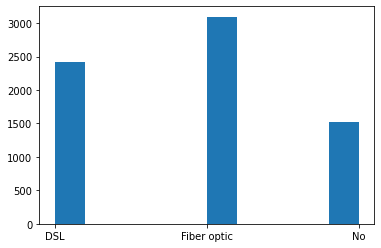

In [250]:
print(df_full['InternetService'].value_counts())
plt.hist(df_full['InternetService']);

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


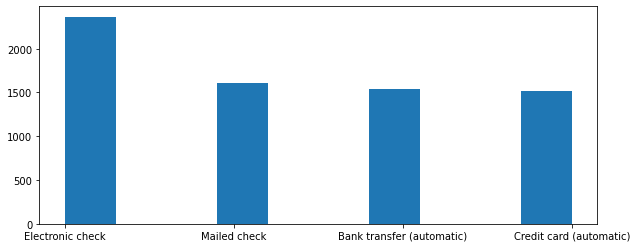

In [251]:
print(df_full['PaymentMethod'].value_counts())
plt.figure(figsize=(10,4))
plt.hist(df_full['PaymentMethod']);

In [252]:
#OHE encoding
df = pd.get_dummies(df_full, columns = ['Type', 'InternetService','PaymentMethod'], drop_first = True)

In [254]:
#вытаскиваем target из EndDate
df['quit'] = pd.Series(np.where(df['EndDate'].values == 'No', 0, 1),df.index)

In [255]:
latest_date = df[df['EndDate'] != 'No']['EndDate'].sort_values().tail(1)

In [256]:
final_date

Timestamp('2020-01-01 00:00:00')

In [257]:
df.loc[df['EndDate'] == 'No','EndDate'] = final_date

In [258]:
df['duration'] = (pd.to_datetime(df['EndDate']) - df['BeginDate']).dt.days

In [259]:
df['quit'].value_counts()

0    5174
1    1869
Name: quit, dtype: int64

Заметили дисбаланс , поэтому будем пробовать upsampling в случае плохой метрики и если есть внутри модели class_weight ,то также будем использовать

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


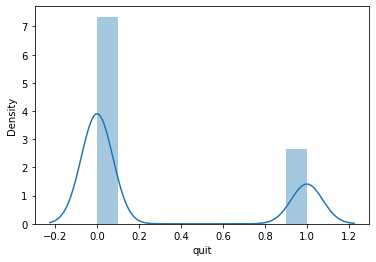

In [260]:
sns.distplot(df['quit'])

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   BeginDate                              7043 non-null   datetime64[ns]
 1   EndDate                                7043 non-null   object        
 2   PaperlessBilling                       7043 non-null   int64         
 3   MonthlyCharges                         7043 non-null   float64       
 4   TotalCharges                           7043 non-null   float32       
 5   MultipleLines                          7043 non-null   int64         
 6   gender                                 7043 non-null   int64         
 7   SeniorCitizen                          7043 non-null   int64         
 8   Partner                                7043 non-null   int64         
 9   Dependents                             7043 non-null 

In [262]:
#убираем ,чтобы модель не смогла по features читить 
df.drop('EndDate', axis = 1, inplace = True)
df.drop('BeginDate', axis = 1, inplace = True)

In [264]:
train_df, test_df = train_test_split(df, test_size = 0.3, random_state = 42)

In [265]:
features_train = train_df.drop('quit', axis = 1)
features_test = test_df.drop('quit', axis = 1)

target_train = train_df['quit']
target_test = test_df['quit']

<h1>RFC model

In [295]:
forestModel = RandomForestClassifier(class_weight = 'balanced', random_state = 42)

forestModel.fit(features_train, target_train)

forestPrediction_Proba = forestModel.predict_proba(features_test)[:,1]

roc_auc_score(target_test, forestPrediction_Proba)

0.8763586925760651

Feature importances:
 1. feature 'duration' (0.2115)
 2. feature 'TotalCharges' (0.1771)
 3. feature 'MonthlyCharges' (0.1565)
 4. feature 'Type_Two year' (0.0583)
 5. feature 'InternetService_Fiber optic' (0.0455)
 6. feature 'PaymentMethod_Electronic check' (0.0381)
 7. feature 'Type_One year' (0.0292)
 8. feature 'OnlineSecurity' (0.0248)
 9. feature 'gender' (0.0236)
10. feature 'PaperlessBilling' (0.0234)
11. feature 'InternetService_No' (0.0225)
12. feature 'TechSupport' (0.0216)
13. feature 'Partner' (0.0210)
14. feature 'Dependents' (0.0192)
15. feature 'OnlineBackup' (0.0188)
16. feature 'MultipleLines' (0.0178)
17. feature 'StreamingMovies' (0.0170)
18. feature 'DeviceProtection' (0.0169)
19. feature 'SeniorCitizen' (0.0164)
20. feature 'StreamingTV' (0.0157)
21. feature 'PaymentMethod_Credit card (automatic)' (0.0133)
22. feature 'PaymentMethod_Mailed check' (0.0117)


<BarContainer object of 22 artists>

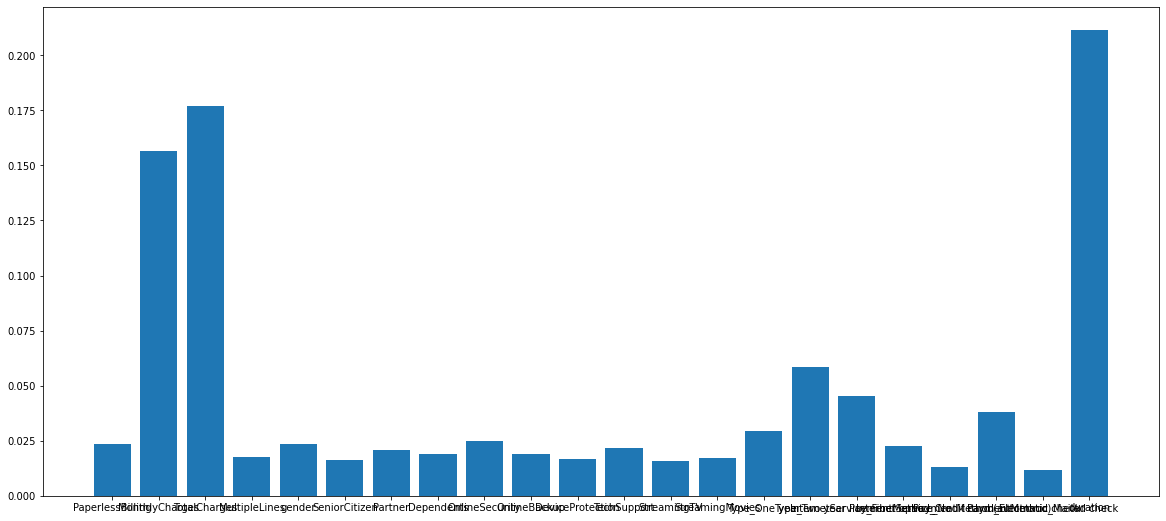

In [296]:
plt.figure(figsize=(20,9))
feature_import2 = forestModel.feature_importances_
col_names = features_train.columns
indices = np.argsort(feature_import2)[::-1]
print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, col_names[idx], feature_import2[idx]))
plt.bar(col_names,feature_import2)

Для случайного леса  видим , что по графику относительно всех остальных отличаются большей значимостью 10 features : 
 1. feature 'duration' (0.2115)
 2. feature 'TotalCharges' (0.1771)
 3. feature 'MonthlyCharges' (0.1565)
 4. feature 'Type_Two year' (0.0583)
 5. feature 'InternetService_Fiber optic' (0.0455)
 6. feature 'PaymentMethod_Electronic check' (0.0381)
 7. feature 'Type_One year' (0.0292)
 8. feature 'OnlineSecurity' (0.0248)
 9. feature 'gender' (0.0236)
 10. feature 'PaperlessBilling' (0.0234)
 <br>
 Остальные уже не так сильно влияют на конечную переменную

In [336]:
rfc_X_train = features_train[['duration','MonthlyCharges','Type_Two year','InternetService_Fiber optic',\
                              'PaymentMethod_Electronic check','Type_One year','OnlineSecurity','gender','PaperlessBilling']]

In [337]:
rfc_X_test = features_test[['duration','MonthlyCharges','Type_Two year','InternetService_Fiber optic',\
                             'PaymentMethod_Electronic check','Type_One year','OnlineSecurity','gender','PaperlessBilling']]

In [338]:
rfc_X_train.corr()

,duration,MonthlyCharges,Type_Two year,InternetService_Fiber optic,PaymentMethod_Electronic check,Type_One year,OnlineSecurity,gender,PaperlessBilling
duration,1.000000,0.255196,0.556983,0.028186,-0.198081,0.195872,0.323482,-0.003605,0.005131
MonthlyCharges,0.255196,1.000000,-0.064528,0.784431,0.273973,-0.004445,0.303200,0.022098,0.361758
Type_Two year,0.556983,-0.064528,1.000000,-0.207933,-0.274685,-0.293496,0.191845,0.004981,-0.155598
InternetService_Fiber optic,0.028186,0.784431,-0.207933,1.000000,0.333991,-0.081352,-0.028235,0.012709,0.334210
PaymentMethod_Electronic check,-0.198081,0.273973,-0.274685,0.333991,1.000000,-0.104785,-0.097504,-0.008552,0.212748
Type_One year,0.195872,-0.004445,-0.293496,-0.081352,-0.104785,1.000000,0.087182,-0.009798,-0.055460
OnlineSecurity,0.323482,0.303200,0.191845,-0.028235,-0.097504,0.087182,1.000000,0.025977,0.012713
gender,-0.003605,0.022098,0.004981,0.012709,-0.008552,-0.009798,0.025977,1.000000,0.015118
PaperlessBilling,0.005131,0.361758,-0.155598,0.334210,0.212748,-0.055460,0.012713,0.015118,1.000000


Почитал про проблемму Мультиколлениарности , и не уверен насколько хорошо я понял проблему ,но думаю эта проблема заключается в том , что когда переменные вытикают друг из друга , то есть имеют сильную корреляцию ,то модель не может из-за их связи с другими переменными вычленить их отдельную логику поведения внутри модели. И по сути насколько я понимаю ,то у нас тут мультиколлениарность между duration , TotalCharges и MonthlyCharges ,так как если исключить одну из них ,то по оставшимся двум можно восстановить третью переменную
<br>
<br>
Много видел способов нахождения мультиколлениарности с помощью статистических методов ,но не понял как их приментяь , к сожалению

<Font color="blue">Проблема только в категориальных, да и то. Тут некоторые признаки сами собой вытекают, из тривиальной логики. Если что, напиши мне - поясню

In [339]:
rfc = GridSearchCV(RandomForestClassifier(criterion = 'entropy', class_weight='balanced'),{
    'max_depth': range(3,15,3),
    'n_estimators': range(10,100, 10),
    'min_samples_split' : range(4,28,4),
    'min_samples_leaf' : range(3,13,2)
}, cv = 5, scoring = 'roc_auc')

In [340]:
rfc.fit(rfc_X_train,target_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=Fal

In [341]:
rfc.best_params_

{'max_depth': 9,
 'min_samples_leaf': 7,
 'min_samples_split': 8,
 'n_estimators': 70}

In [342]:
rfc.best_score_

0.8588359631000622

In [373]:
forestModel = RandomForestClassifier(class_weight = 'balanced',criterion = 'entropy', max_depth=9, min_samples_leaf=7, min_samples_split=8, n_estimators = 70, random_state = 42)

forestModel.fit(rfc_X_train, target_train)

forestPrediction_Proba = forestModel.predict_proba(rfc_X_test)[:,1]

roc_auc_score(target_test, forestPrediction_Proba)

0.8721017765733212

In [374]:
forestPrediction = forestModel.predict(rfc_X_test)
accuracy_score(target_test,forestPrediction)

0.7893989588263133

<h1>CatBoostClassifier

In [344]:
train_dataset = Pool(features_train, target_train)
test_dataset = Pool(features_test, target_test)

In [345]:
modelCat = CatBoostClassifier(loss_function = 'CrossEntropy',learning_rate = 0.03, random_state = 42)
modelCat.fit(train_dataset, eval_set = test_dataset, plot = True, verbose = False)
catPrediction_Proba = modelCat.predict_proba(features_test)[:,1]
roc_auc_score(target_test, catPrediction_Proba)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.9221574713658582

,Feature Id,Importances
0,duration,32.404539
1,TotalCharges,19.098579
2,MonthlyCharges,12.937729
3,Type_Two year,6.252199
4,InternetService_Fiber optic,3.576914
5,Type_One year,2.771913
6,InternetService_No,2.387129
7,PaymentMethod_Electronic check,2.001646
8,PaperlessBilling,1.982224
9,MultipleLines,1.693224


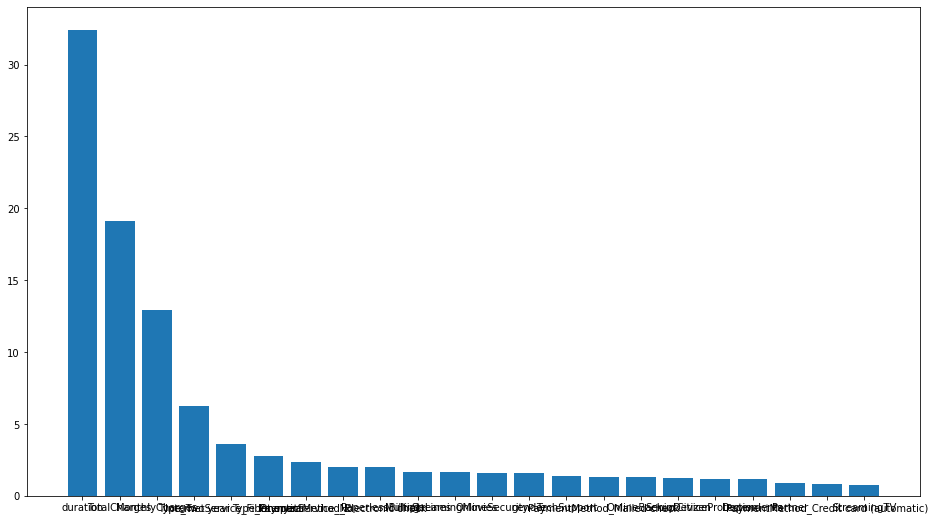

In [346]:
#feature Importance
plt.figure(figsize=(16,9))
feature_import = modelCat.get_feature_importance(train_dataset, prettified = True)
plt.bar(feature_import['Feature Id'],feature_import['Importances'])
feature_import

Здесь также можно выделить топ 11 значимых features,т.к. разница в важности между 10 и 11 не такая большая :
1.	duration	32.404539
2.	TotalCharges	19.098579 (убран из-за мультиколлениарности)
3.	MonthlyCharges	12.937729
4.	Type_Two year	6.252199
5.	InternetService_Fiber optic	3.576914
6.	Type_One year	2.771913
7.	InternetService_No	2.387129
8.	PaymentMethod_Electronic check	2.001646
9.	PaperlessBilling	1.982224
10.	MultipleLines	1.693224
11.	StreamingMovies	1.686189

Остальные будем считать менее важны на конечную переменную

In [358]:
cat_X_train = features_train[['duration','Type_Two year','InternetService_Fiber optic',\
                              'Type_One year','PaymentMethod_Electronic check','PaperlessBilling','MultipleLines','StreamingMovies','InternetService_No']]
cat_X_test = features_test[['duration','Type_Two year','InternetService_Fiber optic',\
                              'Type_One year','PaymentMethod_Electronic check','PaperlessBilling','MultipleLines','StreamingMovies','InternetService_No']]
train_dataset = Pool(cat_X_train, target_train)
test_dataset = Pool(cat_X_test, target_test)

In [359]:
modelCat = CatBoostClassifier( random_state = 42)
gsearchCat = GridSearchCV(modelCat,{
    'iterations': [400,500,600,1000],
    'learning_rate' : [0.03],
    'depth' : range(3,15,3),
    'verbose' : [False]
}, cv = 5,scoring = 'roc_auc')

In [360]:
gsearchCat.fit(cat_X_train,target_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f3609adeb38>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': range(3, 15, 3),
                         'iterations': [400, 500, 600, 1000],
                         'learning_rate': [0.03], 'verbose': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [361]:
gsearchCat.best_params_

{'depth': 3, 'iterations': 1000, 'learning_rate': 0.03, 'verbose': False}

In [362]:
gsearchCat.best_score_

0.8860233784580416

In [368]:
modelCat = CatBoostClassifier(loss_function = 'CrossEntropy',iterations = 1000, depth = 3,learning_rate = 0.03, random_state = 42)

In [369]:
modelCat.fit(train_dataset, eval_set = test_dataset, verbose = False)

In [370]:
catPrediction_Proba = modelCat.predict_proba(cat_X_test)[:,1]

In [371]:
roc_auc_score(target_test, catPrediction_Proba)

0.8991414851491875

In [372]:
catPrediction = modelCat.predict(cat_X_test)
accuracy_score(target_test,catPrediction)

0.8438239469947941

В итоге получили лучшую модель: CatBoost с roc_auc = 0.899 и точностью в 84%

<h2>Ответы на вопросы:</h2>

<strong>Разбор пунктов плана:</strong>
<p>
Первым пунктом - загрузили данные и сделали первые выводы о датасетах и их целостности
</p>

Второй и третий пункт в ходе работы поменялись местами и в итоге сначала проделал EDA ,где нашел особенность - основное количество пользователей ,которые покинули Телеком - сделали это в этот же месяц , тем самым проблема в том ,что пользователи не задерживаются надолго и возмужно абьюзят возможно услуги для нового пользователя

<p>
В третьем пункте предобработали данные : перевели данные в формат для модели , сделали OHE кодировку 
</p>

<p>
В плане писал разделение данных на обучение , тест и валидацию , но в итоге использовал GridSearchCV и потребность в 3ех разделениях отпала. Сначала обучил менее ресурсоемкую модель - RandomForest ,а после уже перешел на CatBoost. Выбрали CatBoost , так как она показала лучше результаты roc_auc на 0.02 , а также точность выше на 5% ,в данном проекте считаю ,что скорость работы модели не кретичная , поэтому считаю ,что ресурсы потраченные на CatBoost стоят повышения метрики для более точного прогноза
</p>

<strong>Основные трудности:</strong>

<p>
Самой большой проблемой было понятие проблемы мультиколлениарности и способов разрешения. Прочитал статьи на разных ресурсах , появилась основная картина что значит , но проблема была в том ,что сложно было понять именно подход с помощью статистических методов ,где используются формулы , нашел более простой метод - с помощью матрицы коллеряции ,которая смогла разрешить в данном случае эту проблему
<br>
Второй уже небольшой проблемой было в GridSearchCV так как изначально хотелось выжить от модели по максимуму и не упустить важный параметр из-за чего работа гридсерча была очень ресурсоемкой ,что на коллабе даже не хватило ОЗУ. Решил проблему сделав сначала более простой GridSearchCV и посмотрел в какую сторону тьюнить лучше параметры , тем самым исключив диапазон и не такой тщательный перебор ,что привело вполне к хорошим результатам
</p>

<strong>Ключевые шаги:</strong>

<p>
Самый основной ключевой шаг это создание дополнительных признаков : duration (длительность контракта на 2020-01-01) и выделение target из EndDate
<br>
Далее убирание признаков с помощью которых модель могла подсмотреть , а также в последующем после feature_importance выделение основных признаков для алгоритма
<br>
Также решение проблемы мультиколлениарности ,что делает модель более адекватной и жизнеспособной
<br>
Настройка гиперпараметров на ряду с кросс-валидацией
<br>
Не совсем про финальный результат ,но еще раз повторюсь - график с помощью которого поняли ,что уходят в основном в первый месяц
</p>


<strong>Финальная модель:</strong>

<p>
CatBoostClassifier(loss_function = 'CrossEntropy',iterations = 1000, depth = 3,learning_rate = 0.03) с такими гиперпараметрами
<br>
roc_auc = 0.8991414851491875
<br>
accuracy = 0.8438239469947941
</p>